# Data Deduplication using Clustering
**Objective**: Learn and implement data deduplication techniques.

**Task**: Hierarchical Clustering for Deduplication

**Steps**:
1. Data Set: Obtain a dataset containing duplicate employee information.
2. Perform Clustering: Use hierarchical agglomerative clustering to cluster the employee
records.
3. Evaluate Duplicates: Determine duplicates by analyzing the clusters formed.
4. Clean Data: Remove duplicate employee records found during clustering.

Initial DataFrame shape: (580, 9)
Sample of initial DataFrame:
   Employee_ID  Age  Years_Experience  Salary  Project_Count   Department  \
0          576   54                19  112258              6           HR   
1          277   27                18   63752              1      Finance   
2          104   24                 3  115993              6    Marketing   
3          177   45                22  102823              5    Marketing   
4          456   56                21   95619              4  Engineering   

  Name_First Name_Last       Full_Name  
0      Chris  Williams  Chris Williams  
1    Michael     Davis   Michael Davis  
2      Sarah     Jones     Sarah Jones  
3      Chris     Davis     Chris Davis  
4      Laura       Doe       Laura Doe  

Sample of Scaled Numerical Data:
        Age  Years_Experience    Salary  Project_Count
0  1.153724          0.483214  1.400709       0.546426
1 -1.270443          0.370431 -0.694223      -1.177878
2 -1.539795         -1.321303

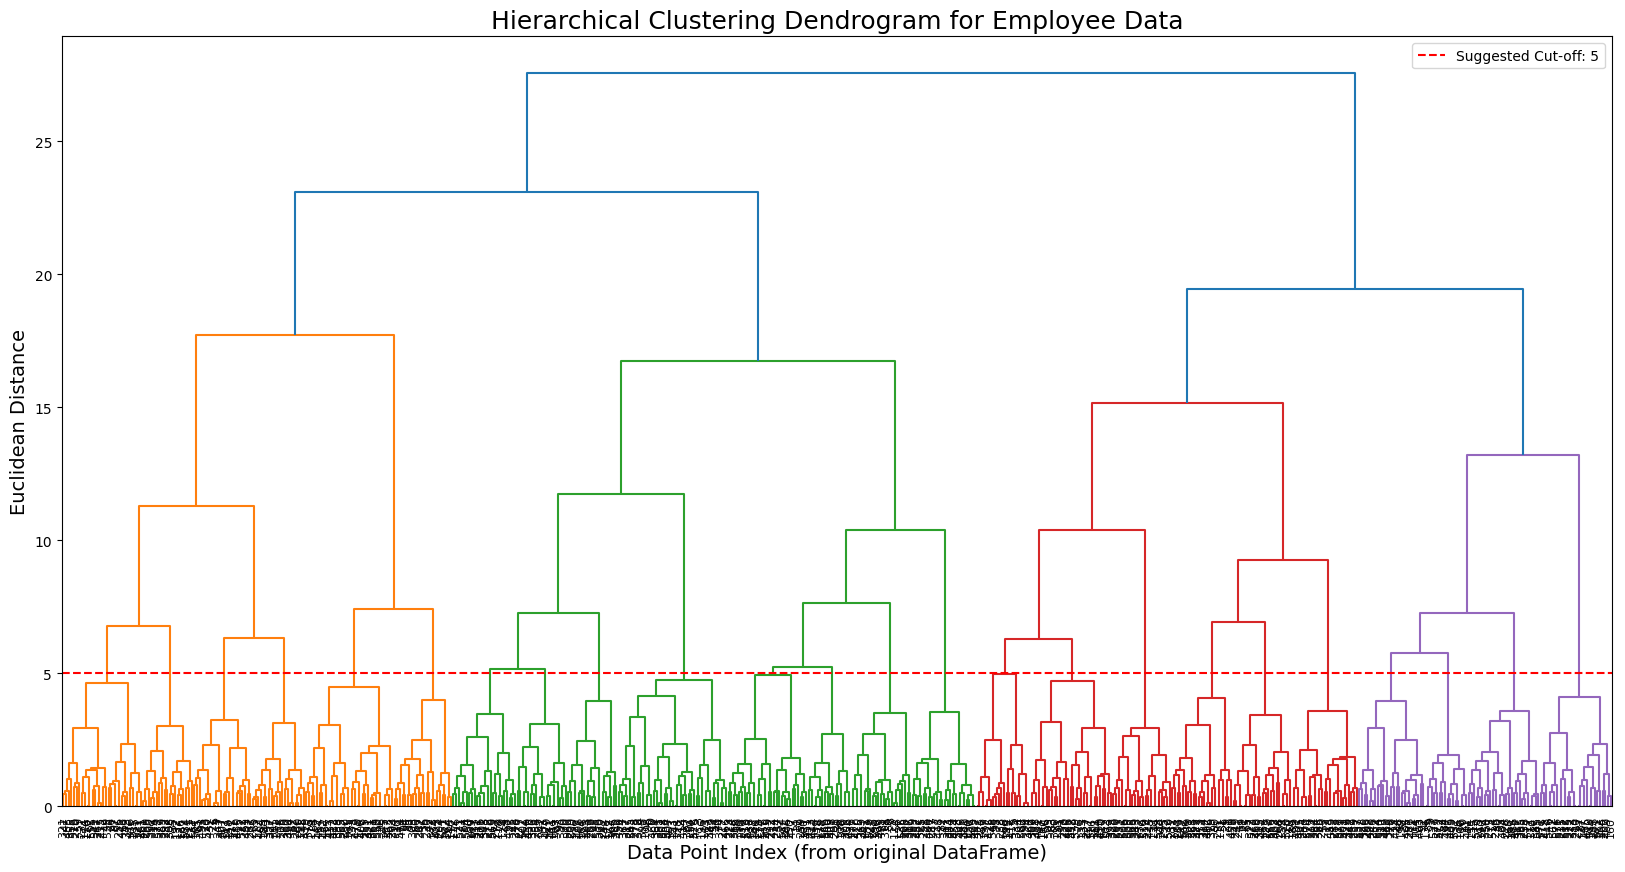


Applying Agglomerative Clustering with distance_threshold = 2.0

DataFrame with Cluster Assignments:
   Employee_ID  Age  Years_Experience  Salary  Project_Count   Department  \
0          576   54                19  112258              6           HR   
1          277   27                18   63752              1      Finance   
2          104   24                 3  115993              6    Marketing   
3          177   45                22  102823              5    Marketing   
4          456   56                21   95619              4  Engineering   

  Name_First Name_Last       Full_Name  Cluster  
0      Chris  Williams  Chris Williams       42  
1    Michael     Davis   Michael Davis       65  
2      Sarah     Jones     Sarah Jones       17  
3      Chris     Davis     Chris Davis       19  
4      Laura       Doe       Laura Doe       42  

Number of records per cluster (top 10 largest):
Cluster
1     16
3     13
12    13
38    12
14    12
26    12
7     12
35    11
2     

In [ ]:
# write your code from here
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

# --- 1. Data Set: Generate Synthetic Employee Information with Duplicates ---
def generate_employee_data(num_employees=500, num_exact_dups=50, num_near_dups=30):
    data = {
        'Employee_ID': range(num_employees),
        'Age': np.random.randint(22, 60, num_employees),
        'Years_Experience': np.random.randint(0, 30, num_employees),
        'Salary': np.random.randint(40000, 120000, num_employees),
        'Project_Count': np.random.randint(0, 10, num_employees),
        'Department': np.random.choice(['HR', 'Engineering', 'Sales', 'Marketing', 'Finance'], num_employees),
        'Name_First': np.random.choice(['John', 'Jane', 'Michael', 'Emily', 'Chris', 'Sarah', 'David', 'Laura'], num_employees),
        'Name_Last': np.random.choice(['Doe', 'Smith', 'Jones', 'Williams', 'Brown', 'Davis', 'Miller', 'Wilson'], num_employees)
    }
    df = pd.DataFrame(data)

    # Combine first and last names for a full name feature
    df['Full_Name'] = df['Name_First'] + ' ' + df['Name_Last']

    # Introduce exact duplicates
    exact_duplicate_rows = df.sample(n=num_exact_dups, replace=False, random_state=42).copy()
    exact_duplicate_rows['Employee_ID'] = np.random.randint(num_employees, num_employees + num_exact_dups, num_exact_dups)
    df = pd.concat([df, exact_duplicate_rows], ignore_index=True)

    # Introduce near-duplicates (slight variations in numerical features)
    near_duplicate_rows = df.sample(n=num_near_dups, replace=False, random_state=100).copy()
    near_duplicate_rows['Employee_ID'] = np.random.randint(num_employees + num_exact_dups, num_employees + num_exact_dups + num_near_dups, num_near_dups)
    near_duplicate_rows['Salary'] = near_duplicate_rows['Salary'] + np.random.randint(-500, 501, num_near_dups) # small salary variation
    near_duplicate_rows['Years_Experience'] = near_duplicate_rows['Years_Experience'] + np.random.randint(-1, 2, num_near_dups) # +/- 1 year
    near_duplicate_rows['Project_Count'] = near_duplicate_rows['Project_Count'] + np.random.randint(0, 2, num_near_dups) # +0 or +1 project
    # For some near-duplicates, introduce typos in names (simple example)
    for i in range(len(near_duplicate_rows)):
        if np.random.rand() < 0.2: # 20% chance to slightly alter first name
            name = list(near_duplicate_rows.iloc[i, near_duplicate_rows.columns.get_loc('Name_First')])
            if len(name) > 2:
                idx_to_change = np.random.randint(1, len(name) - 1)
                name[idx_to_change] = chr(ord(name[idx_to_change]) + np.random.choice([-1, 1]))
                near_duplicate_rows.iloc[i, near_duplicate_rows.columns.get_loc('Name_First')] = "".join(name)
    near_duplicate_rows['Full_Name'] = near_duplicate_rows['Name_First'] + ' ' + near_duplicate_rows['Name_Last']
    df = pd.concat([df, near_duplicate_rows], ignore_index=True)

    # Shuffle the DataFrame
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    return df
employee_df = generate_employee_data(num_employees=500, num_exact_dups=50, num_near_dups=30)
print(f"Initial DataFrame shape: {employee_df.shape}")
print("Sample of initial DataFrame:")
print(employee_df.head())

# Features for clustering (numerical features)
# Note: For real-world names/text, you'd typically use fuzzy matching or text embeddings
# after initial clustering or as part of a more sophisticated blocking strategy.
numerical_features = ['Age', 'Years_Experience', 'Salary', 'Project_Count']
X_numerical = employee_df[numerical_features]

# --- 2. Preprocess: Standardize the numerical data ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numerical)
X_scaled_df = pd.DataFrame(X_scaled, columns=numerical_features, index=employee_df.index)
print("\nSample of Scaled Numerical Data:")
print(X_scaled_df.head())

# --- 3. Perform Clustering: Hierarchical Agglomerative Clustering ---
# Calculate the linkage matrix for the dendrogram
# 'ward' linkage minimizes the variance of the clusters being merged.
linked = linkage(X_scaled, method='ward')

# Plot the dendrogram to visualize clusters and help determine distance threshold
plt.figure(figsize=(20, 10))
dendrogram(linked,
           orientation='top',
           labels=employee_df.index.tolist(), # Use DataFrame indices as labels
           distance_sort='descending',
           show_leaf_counts=True,
           leaf_rotation=90,
           leaf_font_size=8)
plt.title('Hierarchical Clustering Dendrogram for Employee Data', fontsize=18)
plt.xlabel('Data Point Index (from original DataFrame)', fontsize=14)
plt.ylabel('Euclidean Distance', fontsize=14)
# Add a horizontal line to suggest a cut-off threshold
# This threshold is chosen visually from the dendrogram;
# a smaller threshold means tighter clusters (more likely to be duplicates)
suggested_threshold = 5 # Adjust based on the dendrogram visually
plt.axhline(y=suggested_threshold, color='r', linestyle='--', label=f'Suggested Cut-off: {suggested_threshold}')
plt.legend()
plt.show()

# Apply Agglomerative Clustering with a chosen distance threshold
# Records closer than this threshold will be in the same cluster
# Choose a distance_threshold based on dendrogram or domain knowledge for deduplication
# A very small threshold will result in many small clusters, ideal for finding duplicates.
# For this synthetic data, a threshold around 2-5 might work well for very close duplicates.
clustering_threshold = 2.0 # Experiment with this value based on dendrogram and desired strictness

print(f"\nApplying Agglomerative Clustering with distance_threshold = {clustering_threshold}")
agg_cluster = AgglomerativeClustering(n_clusters=None, # None means distance_threshold must be set
                                      distance_threshold=clustering_threshold,
                                      linkage='ward') # 'ward' linkage for this example

employee_df['Cluster'] = agg_cluster.fit_predict(X_scaled)

print("\nDataFrame with Cluster Assignments:")
print(employee_df.head())
print(f"\nNumber of records per cluster (top 10 largest):\n{employee_df['Cluster'].value_counts().head(10)}")
print(f"Total number of clusters formed: {employee_df['Cluster'].nunique()}")

# --- 4. Evaluate and Clean Data: Identify and Remove Duplicates within Clusters ---

deduplicated_records = []
duplicates_removed_count = 0

# Group by cluster
grouped_by_cluster = employee_df.groupby('Cluster')

for cluster_id, cluster_group in grouped_by_cluster:
    if len(cluster_group) == 1:
        # If a cluster has only one member, it's unique by definition (at this threshold)
        deduplicated_records.append(cluster_group.iloc[0])
    else:
        # If a cluster has multiple members, these are potential duplicates/near-duplicates
        # We need a strategy to select one representative and discard others.
        # For this example, we'll use exact match on numerical features within the cluster
        # and then select the first occurrence of each unique combination.
        # In a real scenario, you'd apply fuzzy matching or a specific tie-breaking rule.

        # Convert numerical features to a hashable tuple for grouping
        cluster_group['features_tuple'] = list(zip(*[cluster_group[col] for col in numerical_features]))
        
        # Group by the exact feature values within this sub-cluster
        sub_grouped = cluster_group.groupby('features_tuple')

        for _, sub_group in sub_grouped:
            if len(sub_group) > 1:
                # These are multiple records in the same exact numerical feature space within a cluster
                duplicates_removed_count += (len(sub_group) - 1)
                # Keep the first record as the representative
                deduplicated_records.append(sub_group.iloc[0])
            else:
                # Unique record within this exact numerical feature space
                deduplicated_records.append(sub_group.iloc[0])

# Create the final deduplicated DataFrame
final_df = pd.DataFrame(deduplicated_records).drop(columns=['Cluster', 'features_tuple'], errors='ignore') # 'errors=ignore' for 'features_tuple' if not all groups create it

print(f"\nTotal duplicates removed: {duplicates_removed_count}")
print(f"Original DataFrame size: {len(employee_df)}")
print(f"Deduplicated DataFrame size: {len(final_df)}")
print("\nSample of Deduplicated DataFrame:")
print(final_df.head())

# --- Verification ---
print("\n--- Verification of Deduplication Impact ---")
# Check exact duplicates based on numerical features before and after
num_exact_dups_before_processing = employee_df.duplicated(subset=numerical_features).sum()
print(f"Number of exact duplicates (based on numerical features) before processing: {num_exact_dups_before_processing}")

num_exact_dups_after_processing = final_df.duplicated(subset=numerical_features).sum()
print(f"Number of exact duplicates (based on numerical features) after hierarchical deduplication: {num_exact_dups_after_processing}")

# Compare unique records in the original vs. final DataFrame based on numerical features
num_unique_records_original = employee_df.drop_duplicates(subset=numerical_features).shape[0]
print(f"Number of truly unique records (numerical features) in original DF: {num_unique_records_original}")
print(f"Number of records in final (deduplicated) DF: {len(final_df)}")

if num_exact_dups_after_processing == 0:
    print("\nSuccess: No exact duplicates (based on numerical features) remaining in the deduplicated DataFrame.")
else:
    print("\nWarning: Some exact duplicates (based on numerical features) might still remain. Adjust 'clustering_threshold' or refine intra-cluster deduplication logic.")
